In [1]:
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import copy
import torch.optim as optim

In [2]:
alexnet = models.alexnet(weights="IMAGENET1K_V1")
selected_models = {'alexnet': alexnet}

In [3]:
print(f"before modification : {selected_models['alexnet'].classifier[-1]}")
for key in selected_models.keys():
    model = selected_models[key]
    # set the learning of all the previous layers to false 
    # (already extracting the image features from their previous training)
    for param in selected_models[key].parameters():
        param.requires_grad = False
    
    # get last_layer size to fully connect our last decision layer
    last_layer = [key for key in model.state_dict().keys()][-2]
    last_layer_size = model.state_dict()[last_layer].shape[-1]
    try:
        selected_models[key].classifier = nn.Sequential(*list(model.classifier)[:-1], nn.Linear(last_layer_size, 15))
    except Exception:
        selected_models[key].fc = nn.Linear(last_layer_size, 15)

print(f"after modification : {selected_models['alexnet'].classifier[-1]}")

before modification : Linear(in_features=4096, out_features=1000, bias=True)
after modification : Linear(in_features=4096, out_features=15, bias=True)


In [4]:
class_names = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}

prepare the different transformation to resize the image

In [5]:
img_sizes = [64, 156, 224]
preprocess_size = {}
for img_size in img_sizes:
    preprocess_size[img_size] = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])

prepare the different transformation to blur the image

In [6]:
sigmas_blur = [(3,3), (7,7), (13,13)]
preprocess_blur = {}
for sigma in sigmas_blur:
    preprocess_blur[sigma] = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.GaussianBlur(kernel_size=sigma, sigma=(7,7)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    ])


In [7]:
df = pd.read_csv("./data/data.csv") # path to images
y = torch.as_tensor(df['label'].values)
image_paths = df['path']

def prepare_data(image_paths, preprocess_image):
    images = []

    for path in image_paths:
        try:
            img = Image.open(path)
            images.append(preprocess_image(img.convert('RGB')))
        except Exception as e:
            pass

    X = torch.stack(images)
    print(X.shape)
    return X

X = prepare_data(image_paths[0:100], preprocess_size[64])

torch.Size([100, 3, 64, 64])


In [8]:
def imshow(inp, axis):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

show an image with the different transformation applied

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 156, 156])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


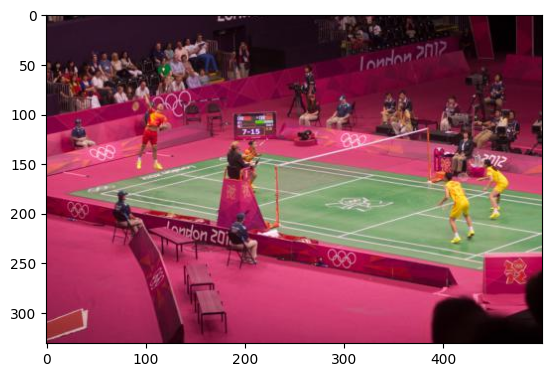

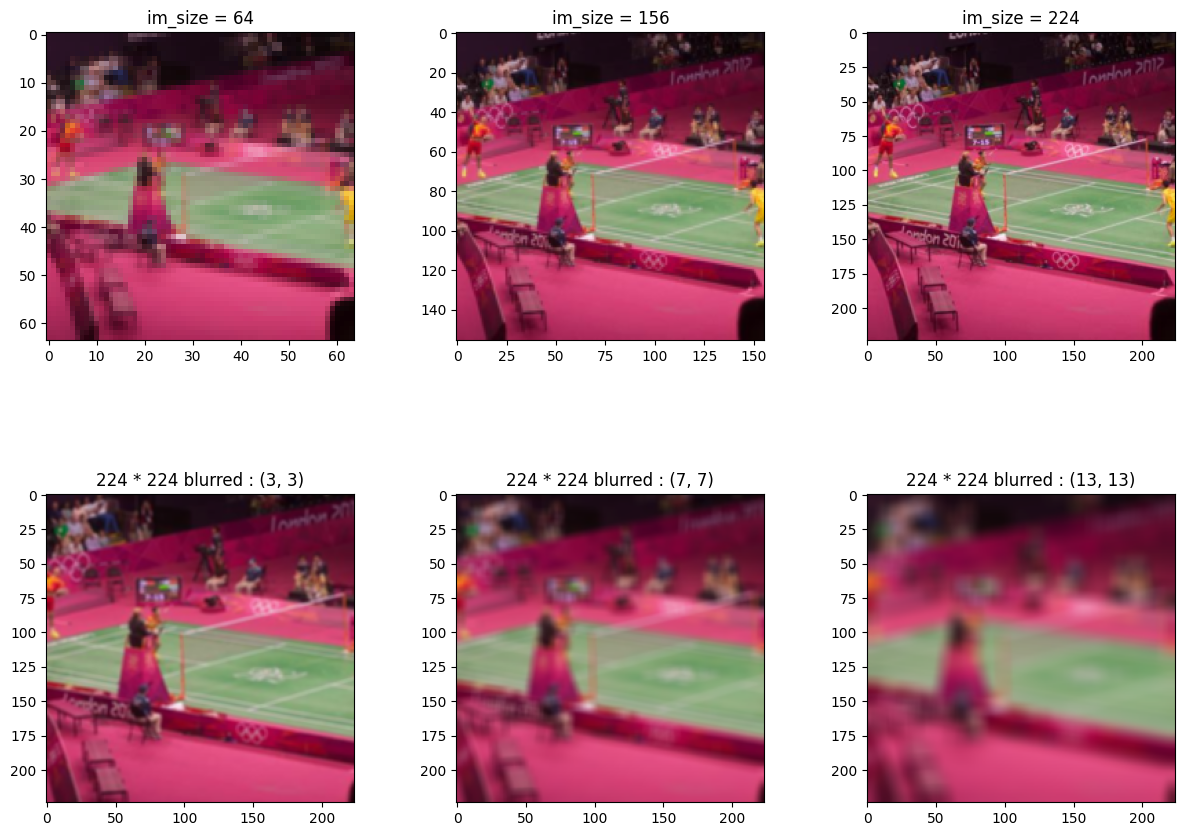

In [9]:
image = mpimg.imread(image_paths[0])
plt.imshow(image)

nb_col = max(len(preprocess_size), len(preprocess_blur))
fig, ax = plt.subplots(2, nb_col, figsize=(10*(nb_col/2), 10))
plt.subplots_adjust(hspace=0.5)

for index, (img_size, preprocess) in enumerate(preprocess_size.items()):
    test_img = prepare_data(image_paths[0:1], preprocess)
    imshow(test_img[0], ax[0,index])
    ax[0,index].set_title(f'im_size = {img_size}')

for index, (sigma, preprocess) in enumerate(preprocess_blur.items()):
    test_img = prepare_data(image_paths[0:1], preprocess)
    imshow(test_img[0], ax[1,index])
    ax[1,index].set_title(f'224 * 224 blurred : {sigma}')
    

In [10]:
def get_batch(X, y, batch_size, iteration):
    start = batch_size * iteration
    end = (batch_size) * (iteration + 1)
    if end > X.shape[0]:
        end = X.shape[0]
    return X[start:end, :, :, :], y[start:end]

batch_x, batch_y = get_batch(X, y, 50, 0)
print(batch_x.shape, batch_y.shape)

torch.Size([50, 3, 64, 64]) torch.Size([50])


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from sklearn.model_selection import train_test_split

def train_val_dataset(train_idx, test_idx):
    datasets = {}
    datasets['X_train'] = X[train_idx,:,:,:]
    datasets['X_test'] = X[test_idx,:,:,:]
    datasets['y_train'] = y[train_idx]
    datasets['y_test'] = y[test_idx]

    return datasets

def train_test_index(X, y, testing_size=0.25):
    train_idx, test_idx = train_test_split(list(range(X.shape[0])), test_size=testing_size)
    return train_idx, test_idx
    
train_idx, test_idx = train_test_index(X, y, testing_size=0.25)
datasets = train_val_dataset(train_idx, test_idx)
print(datasets['X_train'].shape)

torch.Size([75, 3, 64, 64])


In [13]:
def train_model(datasets, model, criterion, optimizer, batch_size = 100, num_epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracies = {}

    X_train, y_train, X_test, y_test = datasets['X_train'], datasets['y_train'], datasets['X_test'], datasets['y_test']

    batch_count = (X_train.shape[0] // batch_size) + 1
    batch_test_count = (X_test.shape[0] // batch_size) + 1

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for num_batch in range(batch_count):
            if (num_batch % 15 == 0):
                print(f'batch train : {num_batch}/{batch_count}')
            inputs, labels = get_batch(X_train, y_train, batch_size, num_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        
        epoch_train_loss = running_loss / datasets[f'X_train'].shape[0]
        epoch_train_acc = running_corrects / datasets[f'X_train'].shape[0]

        # testing set
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for num_batch in range(batch_test_count):
            if (num_batch % 15 == 0):
                print(f'batch test : {num_batch}/{batch_test_count}')
            inputs, labels = get_batch(X_test, y_test, batch_size, num_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_test_loss = running_loss / datasets[f'X_test'].shape[0]
        epoch_test_acc = running_corrects / datasets[f'X_test'].shape[0]

        accuracies[epoch] = {'train accuracy' : epoch_train_acc.item(), 
                            'test accuracy' : epoch_test_acc.item(),
                            'train loss': epoch_train_loss,
                            'test loss': epoch_test_loss}

        # deep copy the model if better
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, accuracies

train the network with different size of images

In [21]:
criterion = nn.CrossEntropyLoss()
model_accuracies = {}
models = {}

for index, (img_size, preprocess) in enumerate(preprocess_size.items()):
    X = prepare_data(image_paths, preprocess)
    if index == 0:
        train_idx, test_idx = train_test_index(X, y, testing_size=0.25)
    datasets = train_val_dataset(train_idx, test_idx)

    model = copy.deepcopy(selected_models['alexnet'])
    model = model.to(device)
    optimizer_ft = optim.Adam(model.parameters(), lr=0.01)
    
    model_opti, model_accuracy = train_model(datasets, model, criterion, optimizer_ft, batch_size=50, num_epochs=5)
    model_scripted = torch.jit.script(model_opti) # Export to TorchScript
    model_accuracies[img_size] = model_accuracy
    model_scripted.save(f'./models/{img_size}.pt') # Save

torch.Size([10303, 3, 64, 64])
Epoch 0/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 1/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 2/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 3/4
ba

In [24]:
import json
with open('models_accuracies_sizes.txt', 'w') as f:
    f.write(json.dumps(model_accuracies))

train the network with blurred images

In [15]:
criterion = nn.CrossEntropyLoss()
model_accuracies = {}

models = {}

for index, (kernel_size, preprocess) in enumerate(preprocess_blur.items()):
    X = prepare_data(image_paths, preprocess)
    if index == 0:
        train_idx, test_idx = train_test_index(X, y, testing_size=0.25)
    datasets = train_val_dataset(train_idx, test_idx)

    model = copy.deepcopy(selected_models['alexnet'])
    model = model.to(device)
    optimizer_ft = optim.Adam(model.parameters(), lr=0.01)
    
    model_opti, model_accuracy = train_model(datasets, model, criterion, optimizer_ft, batch_size=50, num_epochs=5)
    model_scripted = torch.jit.script(model_opti) # Export to TorchScript
    model_accuracies[kernel_size] = model_accuracy
    model_scripted.save(f'./models/alexnet_blurred_{kernel_size}.pt') # Save

torch.Size([10303, 3, 224, 224])
Epoch 0/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 1/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 2/4
batch train : 0/155
batch train : 15/155
batch train : 30/155
batch train : 45/155
batch train : 60/155
batch train : 75/155
batch train : 90/155
batch train : 105/155
batch train : 120/155
batch train : 135/155
batch train : 150/155
batch test : 0/52
batch test : 15/52
batch test : 30/52
batch test : 45/52
Epoch 3/4


In [18]:
import json
change_keys = {str(key): value for key, value in model_accuracies.items()}
with open('models_accuracies_blurred.txt', 'w') as f:
    f.write(json.dumps(change_keys))